In [1]:
from tqdm.notebook import tqdm
import pdb # pdb.set_trace()

In [80]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Dlnpyutils
from dlnpyutils.utils import bspline,mad,interp

# dust_extinction
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

class Aetas():
    '''
    A class to calculate a star's extinction, age and mass using PARSEC isochrones with 
    Gaia (E)DR3 and 2MASS photometry.
    '''
    def __init__(self,teff,logg,abund,obsphot,distance,isochrones,ext_law='CCM89',rv=3.1):
        
        '''
        Inputs:
        ------
            teff:       2x1 array-like
                        Teff and error of star np.array([teff,teff_err])
                        
            logg:       2x1 array-like
                        Log(g) and error of star np.array([logg,logg_err])
                    
            abund:      2x1 array-like
                        first column is [M/H] and [Alpha/M] and the second column is the errors
                    
            obs_phot:   6x2 array-like
                        first column is BP, G, RP, J, H, and K and the second column is the errors
                        
            distance:   float
                        distance to star in pc
                    
            isochrones: astropy Table 
                        PARSEC isochrone table
                        
            ext_law:    string, optional
                        extinction law to use. Default is CCM89.
                        
                        Available Extinction Laws: 
                        -------------------------

                        CCM89 - Cardelli, Clayton, & Mathis 1989
                        O94 - O'Donnell 1994
                        F99 - Fitzpatrick 1999
                        F04 - Fitzpatrick 2004
                        VCG04 - Valencic, Clayton, & Gordon 2004
                        GCC09 - Grodon, Cartledge, & Clayton 2009
                        M14 - Maiz Apellaniz et al 2014
                        F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                        D22 - Decleir et al. 2022
                        
            rv:         float, optional
                        Rv (=Av/E(B-V)) extinction law slope. Default is 3.1 
                        (required to be 3.1 if ext_law = 'F99')

        '''
        
        # Teff and log(g)
        self.teff = teff[0] # temperature
        self.teff_err = teff[1] # temperature error
        self.logg  = logg[0] # log(g)
        self.logg_err = logg[1] # log(g) error
        
        # Salaris [Fe/H] Asplund 2021 et al.
        self.salfeh = abund[0,0]+np.log10(0.659*(10**(abund[1,0]))+0.341) # Salaris Corrected [Fe/H]
        self.salfeh_err = np.sqrt(abund[0,1]**2+((1-0.341/(0.659*(10**(abund[1,0]))+0.341))*abund[1,1])**2)
        self.phot = obsphot[:,0] # photometry
        self.phot_err = obsphot[:,1] # photometry errors
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # Absolute Magnitudes Not Derreddened
        self.absphot = self.phot-self.distmod
        
        # PARSEC isochrones
        self.labels = ['G_BPEDR3mag','GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']
        
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        self.uniq_ages = np.unique(self.iso['logAge'])
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands in units of microns
        self.rv = rv
        self.leff = np.array([0.5387,0.6419,0.7667,1.2345,1.6393,2.1757]) #BP, G, RP, J, H, K
        self.extlaw_coeff = self.extcoeff(law=ext_law)
        
    #################
    ### Utilities ###
    #################
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value

        Inputs:
        ------
            data:  array-like
                   data to search through

            value: float or int
                   value of interest

        Output:
        ------
            close: float or int
                   value in data closest to given value
        '''
        
        data = np.asarray(data)
        
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value

        Inputs:
        ------
            data:   array-like
                    data to search through

            value:  float or int
                    value of interest

        Output:
        ------
            close1: float or int
                    closest value under the given value

            close2: float or int
                    closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    ##################
    ### Extinction ###
    ##################
    
    def extcoeff(self,rv=3.1,law='CCM89'):#,ref='G'):

        '''
        Calculate the relative extincion law coefficients for a given wavelength relative to the 
        BP, G, RP, J, H, K or user defined band

        Input:
        -----
            wavelength: float
                        Effective wavelength of band of interest in microns

            law:        str
                        extinction law to use

                        Available Extinction Laws: 
                        -------------------------

                        CCM89 - Cardelli, Clayton, & Mathis 1989
                        O94 - O'Donnell 1994
                        F99 - Fitzpatrick 1999
                        F04 - Fitzpatrick 2004
                        VCG04 - Valencic, Clayton, & Gordon 2004
                        GCC09 - Grodon, Cartledge, & Clayton 2009
                        M14 - Maiz Apellaniz et al 2014
                        F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                        D22 - Decleir et al. 2022

            rv:         float
                        Rv (=Av/E(B-V)) extinction law slope. Default is 3.1

        Output:
        ------
            ext_coeff:  float
                        calculated extinction coefficients for the BP, G, RP, J, H, and K bands 
                        relative to the Gaia G band

        '''

        leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}

        # select the extinction model
        if law == 'CCM89':
            ext_model = CCM89(Rv=rv)

        elif law == 'O94':
            ext_model = O94(Rv=rv)

        elif law == 'F99':
            ext_model = F99(Rv=rv)

        elif law == 'F04':
            ext_model = F04(Rv=rv)

        elif law == 'VCG04':
            ext_model = VCG04(Rv=rv)

        elif law == 'GCC09':
            ext_model = GCC09(Rv=rv)

        elif law == 'M14':
            ext_model = M14(Rv=rv)

        elif law == 'F19':
            ext_model = F19(Rv=rv)

        elif law == 'D22':
            ext_model = D22(Rv=rv)   

        # Calculate the relative extinction coefficient
        ext_coeff_array = ext_model(np.reciprocal(self.leff*u.micron))

        return ext_coeff_array
    
    def extinction(self):
        '''
        Calulate the extinctions for the BP, G, RP, J, H, and K bands
        
        Output:
        ------
            ext: 6x2 array
                 first column is the extinction values and the second is the errors
            
        '''
        
        # isochrone magnitude labels
        color_labels = np.array([['G_BPEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag'],
                                 ['GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']]).T
        
        # pick isochrone points with temperatures within 500 K of the star's Teff
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+500.))&
                           (self.iso['logTe']>np.log10(self.teff-500.)))
        
        iso_ = self.iso[teffcut]
        
        # check to make sure teff of star is in range of the isochrone
        if np.size(np.squeeze(teffcut))==0:
            self.ext = 999999.0*np.ones((6,2))
            return 999999.0*np.ones((6,2))
    
        # get colors and errors
        obs_colors = np.delete(self.phot-self.phot[1],1)
        obs_colors[1:] = -1*obs_colors[1:]
        obs_colors_err = np.delete(np.sqrt(self.phot_err**2+self.phot_err[1]**2),1)
        
        # create "reddening" vector (slightly modified from the normal definition)
        red_vec = np.delete(1-self.extlaw_coeff/self.extlaw_coeff[1],1)
        red_vec[0] = -1*red_vec[0]
        
        ext_vec = self.extlaw_coeff/self.extlaw_coeff[1]
        
        # calculate the intrinsic colors using a b-spline
        bspline_vec = 999999.0*np.ones(5)
        bspline_vec_deriv = 999999.0*np.ones(5)
        
        for i in range(5):
            try:
                # Interpolate the color-Teff relation using a b-spline
                color = (iso_[color_labels[i,0]]-iso_[color_labels[i,1]])
                logTe = iso_['logTe']

                bspl = bspline(logTe,color)
                bspline_vec[i] = bspl(np.log10(self.teff))
                bspline_vec_deriv[i] = bspl.derivative()(np.log10(self.teff))
                
            except:
                try:
                    bspl = bspline(logTe,color,extrapolate=True)
                    bspline_vec[i] = bspl(np.log10(self.teff))
                    bspline_vec_deriv[i] = bspl.derivative()(np.log10(self.teff))
                
                except:
                    bspline_vec[i] = 999999.0
                    bspline_vec_deriv[i] = 999999.0
                
        # calculate the extinctions and errors
        color_diff = obs_colors-bspline_vec
        bspl_errs = np.abs((bspline_vec_deriv*self.teff_err)/(self.teff*np.log(10)))
        color_diff_err = np.sqrt(obs_colors_err**2+bspl_errs**2)
        
        # find bad values this should take care of bad values from the spline
        neg_cut = np.where(color_diff>0)
        
        # if all bad return bad values
        if np.size(np.squeeze(neg_cut))==0:
            self.ext = 999999.0*np.ones((6,2))
            return 999999.0*np.ones((6,2))
        
        # calculate the extinction value and error
        ag = np.dot(red_vec[neg_cut],color_diff[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        ag_err = np.dot(red_vec[neg_cut],color_diff_err[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        
        
        ext = 999999.0*np.ones((6,2))
        ext[:,0] = ext_vec*ag
        ext[:,1] = ext_vec*ag_err
        
        self.ext = ext
        
        return ext
    
    ##############################################
    ### Magnitudes, Extinctions, Ages & Masses ###
    ##############################################
    
    def teff_2_appmags(self,teff,age,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff:     float
                      Teff of star 
                      
            age:      float
                      age of star
        
        Output:
        ------
            calc_mag: 6x2 array 
                      expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        extincts = self.ext[:,0]
        
        lgage = np.log10(age*10**9)
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
#             if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])

            extrap = False

            if 10**min(iso_['logTe'])-self.teff > 100 or self.teff - 10**max(iso_['logTe']) > 100:
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(6)
            for i in range(6):
                
                if extrap:
                    mag_spl = interp(iso_['logTe'],iso_[self.labels[i]],lgteff,
                                     assume_sorted=False,extrapolate=True)
                else:
                    mag_spl = bspline(iso_['logTe'],iso_[self.labels[i]])
                
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
            
            ### logg spline
            if extrap:
                lgg_spl = interp(iso_['logTe'],iso_['logg'],lgteff,assume_sorted=False,extrapolate=True)
                
            else:
                lgg_spl = utils.bspline(iso_['logTe'],iso_['logg'])
            
            calc_logg = lgg_spl(lgteff)
            
            self.age_spl_interp_deriv = mp.median(np.diff(self.unique_ages)/2.0)
                
            return np.append(calc_mags, calc_logg)
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            ### Temperature Check
            
            extrap_lo = False
            extrap_hi = False
            
#             pdb.set_trace()
            
            if 10**min(iso_lo['logTe'])-self.teff > 100 or self.teff - 10**max(iso_lo['logTe']) > 100:
#                 print('outside iso_lo')
#                 print('Age',10**lgage_lo/10**9)
#                 print('max iso_lo',max(iso_lo['logTe']))
#                 print('min iso_lo',min(iso_lo['logTe']))
#                 print('Teff',np.log10(self.teff))
#                 print('Lower - Teff',10**min(iso_lo['logTe'])-self.teff)
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            if 10**min(iso_hi['logTe'])-self.teff > 100 or self.teff - 10**max(iso_hi['logTe']) > 100:
#                 print('outside iso_hi')
#                 print('max iso_hi',max(iso_hi['logTe']))
#                 print('min iso_hi',min(iso_hi['logTe']))
#                 print('Teff',np.log10(self.teff))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                extrap_lo = True
                
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                extrap_hi = True
            
#             pdb.set_trace()    
            
            ### use a b-spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(6)
            for i in range(6):
                
                if extrap_lo:
                    mag_spl_lo = interp(iso_lo['logTe'],iso_lo[self.labels[i]],lgteff,
                                        assume_sorted=False,extrapolate=True)
                        
                else:
                    mag_spl_lo = bspline(iso_lo['logTe'],iso_lo[self.labels[i]])(lgteff)
                    
                if extrap_hi:
                    mag_spl_hi = interp(iso_hi['logTe'],iso_hi[self.labels[i]],lgteff,
                                        assume_sorted=False,extrapolate=True)
                        
                else:
                    mag_spl_hi = bspline(iso_hi['logTe'],iso_hi[self.labels[i]])(lgteff)
                 
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],[mag_spl_lo,mag_spl_hi],1)))
                self.age_spl_interp_deriv = age_spl_interp.deriv()
                
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
            
            ### logg spline
            if extrap_lo:
                lgg_spl_lo = interp(iso_lo['logTe'],iso_lo['logg'],lgteff,assume_sorted=False,extrapolate=True)
                
            else:
                lgg_spl_lo = bspline(iso_lo['logTe'],iso_lo['logg'])(lgteff)
                
            if extrap_hi:
                lgg_spl_hi = interp(iso_hi['logTe'],iso_hi['logg'],lgteff,assume_sorted=False,extrapolate=True)
            
            else:
                lgg_spl_hi = bspline(iso_hi['logTe'],iso_hi['logg'])(lgteff)
            
            lgg_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],[lgg_spl_lo,lgg_spl_hi],1)))
            
            calc_logg = lgg_spl_interp(age)
            

            return np.append(calc_mags, calc_logg)
        
    #######################
    ### Ages and Masses ###
    #######################
    
    def isochrone_check(self,flags=False,filename=None):
        '''
        Diagnostic to check if a star falls on isochrones or not. 
        
        Input:
        -----
            flags:    boolean
                      if True return flags stating if the star falls on the isochrones.
                      prints a flag for Teff, log(g)
        
            filename: str (optional)
                      filename without extension
        '''
        
        color_labels = np.array([['G_BPEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag'],
                                 ['GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']]).T
        
        colorteff_labels = np.array(['BP - G','G - RP','G - J','G - H','G - Ks'])
        
        # get colors
        obs_colors = np.delete(self.phot-self.phot[1],1)
        obs_colors[1:] = -1*obs_colors[1:]
#         obs_colors_err = np.delete(np.sqrt(self.phot_err**2+self.phot_err[1]**2),1)
        
        ### Spectroscopic HR diagram
        plt.figure(figsize=[12,10])
        plt.scatter(10**self.iso['logTe'],self.iso['logg'],
                    c=10**self.iso['logAge']/10**9,cmap='nipy_spectral')
        plt.colorbar()
        plt.scatter(self.teff,self.logg)
        
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
        
        plt.xlabel(r'Teff')
        plt.ylabel(r'Log(g)')
        
        if filename != None:
            plt.savefig('{}.png'.format(filename),bbox_inches='tight')
        plt.show()
        
        ### Color Teff relationships
        fig,ax = plt.subplots(figsize=[72,10])
        
        for i in range(5):
            color = (iso_[color_labels[i,0]]-iso_[color_labels[i,1]])
            im = ax[i].scatter(10**self.iso['logTe'],color,c=10**self.iso['logAge']/10**9,cmap='nipy_spectral')
            ax[i].scatter(self.teff,obs_colors[i],marker='*',s=500)
            
            ax[i].set_xlabel(r'Teff')
            ax[i].set_ylabel(r'{}'.format(colorteff_labels[i]))
        
        fig.colorbar(im, ax=ax.ravel().tolist())
        
        if filename != None:
            plt.savefig('{}.png'.format(filename),bbox_inches='tight')
        plt.show()

    def get_age(self,guess_ages=np.linspace(0.012,17.)[::10],verbose=False):
        '''
        Find best fitting age for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: array 
                        initial guesses for ages in Gyr

            
        Output:
        ------
            age:        float 
                        best age according to chi^2 space search
                        
            chi:        float
                        best chi^2 according to chi^2 space search
                        
            rms:        float
                        RMSE of the result
            
        '''
            
        # initialize lists
        
        curve_ages = []
        curve_chi = []
        curve_rms = []

        # loop over age and ak space 
        for j in range(len(guess_ages)): 
            try:
                # calculate best fit parameters and covariance matrix
                obs_quants = np.append(np.copy(self.phot),self.logg)
                obs_quants_err = np.append(np.copy(self.phot_err),self.logg_err)


                popt,pcov = curve_fit(self.teff_2_appmags,self.teff,obs_quants,p0=guess_ages[j],
                                      method='lm',sigma=obs_quants_err,
                                      absolute_sigma=True,maxfev=5000)

                # populate lists
                curve_ages.append(popt[0])
#                 print(self.teff_2_appmags(self.teff,popt[0]))
                curve_mags_logg = np.asarray(self.teff_2_appmags(self.teff,popt[0]))

                curve_chi.append(sum((curve_mags_logg-obs_quants)**2/obs_quants_err**2))
                curve_rms.append(np.std(curve_mags_logg-obs_quants))
    #             curve_rms.append(np.sqrt(sum((curve_mags_logg-obs_quants)**2)/len(curve_mags_logg)))

            except:
                # populate lists
                curve_ages.append(999999.0)
                curve_chi.append(999999.0)
                curve_rms.append(999999.0)

#         pdb.set_trace()
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        age = np.asarray(curve_ages)[idx]
        chi = np.asarray(curve_chi)[idx]
        rms = np.asarray(curve_rms)[idx]
        self.age = age
        self.chi = chi
        self.rms = rms

        return age, chi, rms
    
    ##############
    ### Masses ###
    ##############
    
    def age_2_mass(self,age):
        '''
        Calculate the mass of a star from its age
        
        Input:
        -----
            age:      2x1 array
                      age of a star in Gyr and associated error

        Output:
        ------
            mass:     float 
                      mass of star in solar masses
            
            mass_err: float
                      error in the calculated mass of the star
        '''

        if self.age == 999999.0:
            return 999999.0
        
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+200.))&
                           (self.iso['logTe']>np.log10(self.teff-200.)))
        iso_ = self.iso[teffcut]
        
        if np.size(iso_) < 2:
            return 999999.0
        try:
            ### calculate the mass and error using interpolation
            bspl = bspline(iso_['logAge'],iso_['Mass'])
            mass = bspl(np.log10(age*10**9))
            
        except:
            mass = 999999.0

        if np.isfinite(mass)==False:
            return 999999.0
        
        return mass

In [52]:
# #Astropy
# import astropy
# from astropy.io import fits
# from astropy.table import Table

# # Dlnpyutils
# from dlnpyutils.utils import bspline,mad,interp

# # dust_extinction
# from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

# # Matplotlib
# import matplotlib
# import matplotlib.pyplot as plt
# # %matplotlib inline
# matplotlib.rcParams.update({'font.size': 25})

# #Numpy/Scipy
# import numpy as np
# import scipy
# from scipy.interpolate import interp1d
# from scipy.optimize import curve_fit

# class Aetas():
#     '''
#     A class to calculate a star's extinction, age and mass using PARSEC isochrones with 
#     Gaia (E)DR3 and 2MASS photometry.
#     '''
#     def __init__(self,teff,logg,abund,obsphot,distance,isochrones,ext_law='CCM89',rv=3.1):
        
#         '''
#         Inputs:
#         ------
#             teff:       2x1 array-like
#                         Teff and error of star np.array([teff,teff_err])
                        
#             logg:       2x1 array-like
#                         Log(g) and error of star np.array([logg,logg_err])
                    
#             abund:      2x1 array-like
#                         first column is [M/H] and [Alpha/M] and the second column is the errors
                    
#             obs_phot:   6x2 array-like
#                         first column is BP, G, RP, J, H, and K and the second column is the errors
                        
#             distance:   float
#                         distance to star in pc
                    
#             isochrones: astropy Table 
#                         PARSEC isochrone table
                        
#             ext_law:    string, optional
#                         extinction law to use. Default is CCM89.
                        
#                         Available Extinction Laws: 
#                         -------------------------

#                         CCM89 - Cardelli, Clayton, & Mathis 1989
#                         O94 - O'Donnell 1994
#                         F99 - Fitzpatrick 1999
#                         F04 - Fitzpatrick 2004
#                         VCG04 - Valencic, Clayton, & Gordon 2004
#                         GCC09 - Grodon, Cartledge, & Clayton 2009
#                         M14 - Maiz Apellaniz et al 2014
#                         F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
#                         D22 - Decleir et al. 2022
                        
#             rv:         float, optional
#                         Rv (=Av/E(B-V)) extinction law slope. Default is 3.1 
#                         (required to be 3.1 if ext_law = 'F99')

#         '''
        
#         # Teff and log(g)
#         self.teff = teff[0] # temperature
#         self.teff_err = teff[1] # temperature error
#         self.logg  = logg[0] # log(g)
#         self.logg_err = logg[1] # log(g) error
        
#         # Salaris [Fe/H] Asplund 2021 et al.
#         self.salfeh = abund[0,0]+np.log10(0.659*(10**(abund[1,0]))+0.341) # Salaris Corrected [Fe/H]
#         self.salfeh_err = np.sqrt(abund[0,1]**2+((1-0.341/(0.659*(10**(abund[1,0]))+0.341))*abund[1,1])**2)
#         self.phot = obsphot[:,0] # photometry
#         self.phot_err = obsphot[:,1] # photometry errors
        
#         # Distance modulus
#         self.distance = distance
#         self.distmod = 5.0*np.log10(distance)-5.0
        
#         # Absolute Magnitudes Not Derreddened
#         self.absphot = self.phot-self.distmod
        
#         # PARSEC isochrones
#         self.labels = ['G_BPEDR3mag','GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']
        
#         self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
#         self.uniq_ages = np.unique(self.iso['logAge'])
        
#         age_idx = []
#         for i in range(len(self.uniq_ages)):
#             ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
#             age_idx.append(np.array([min(ages),max(ages)]))
        
#         self.age_idx = np.asarray(age_idx)
                
#         # Effective Wavelengths of different passbands in units of microns
#         self.rv = rv
#         self.leff = np.array([0.5387,0.6419,0.7667,1.2345,1.6393,2.1757]) #BP, G, RP, J, H, K
#         self.extlaw_coeff = self.extcoeff(law=ext_law)
        
#     #################
#     ### Utilities ###
#     #################
        
#     def closest(self,data,value):
#         '''
#         Find nearest value in array to given value

#         Inputs:
#         ------
#             data:  array-like
#                    data to search through

#             value: float or int
#                    value of interest

#         Output:
#         ------
#             close: float or int
#                    value in data closest to given value
#         '''
        
#         data = np.asarray(data)
        
#         return data[(np.abs(np.subtract(data,value))).argmin()]
    
#     def neighbors(self,data,value):
#         '''
#         Find values of two elements closest to the given value

#         Inputs:
#         ------
#             data:   array-like
#                     data to search through

#             value:  float or int
#                     value of interest

#         Output:
#         ------
#             close1: float or int
#                     closest value under the given value

#             close2: float or int
#                     closest value over the given value
#         '''
    
#         data = np.asarray(data)
#         close1 = data[(np.abs(np.subtract(data,value))).argmin()]
#         data = data[np.where(data!=close1)]
#         close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
#         return close1,close2
    
#     ##################
#     ### Extinction ###
#     ##################
    
#     def extcoeff(self,rv=3.1,law='CCM89'):#,ref='G'):

#         '''
#         Calculate the relative extincion law coefficients for a given wavelength relative to the 
#         BP, G, RP, J, H, K or user defined band

#         Input:
#         -----
#             wavelength: float
#                         Effective wavelength of band of interest in microns

#             law:        str
#                         extinction law to use

#                         Available Extinction Laws: 
#                         -------------------------

#                         CCM89 - Cardelli, Clayton, & Mathis 1989
#                         O94 - O'Donnell 1994
#                         F99 - Fitzpatrick 1999
#                         F04 - Fitzpatrick 2004
#                         VCG04 - Valencic, Clayton, & Gordon 2004
#                         GCC09 - Grodon, Cartledge, & Clayton 2009
#                         M14 - Maiz Apellaniz et al 2014
#                         F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
#                         D22 - Decleir et al. 2022

#             rv:         float
#                         Rv (=Av/E(B-V)) extinction law slope. Default is 3.1

#         Output:
#         ------
#             ext_coeff:  float
#                         calculated extinction coefficients for the BP, G, RP, J, H, and K bands 
#                         relative to the Gaia G band

#         '''

#         leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}

#         # select the extinction model
#         if law == 'CCM89':
#             ext_model = CCM89(Rv=rv)

#         elif law == 'O94':
#             ext_model = O94(Rv=rv)

#         elif law == 'F99':
#             ext_model = F99(Rv=rv)

#         elif law == 'F04':
#             ext_model = F04(Rv=rv)

#         elif law == 'VCG04':
#             ext_model = VCG04(Rv=rv)

#         elif law == 'GCC09':
#             ext_model = GCC09(Rv=rv)

#         elif law == 'M14':
#             ext_model = M14(Rv=rv)

#         elif law == 'F19':
#             ext_model = F19(Rv=rv)

#         elif law == 'D22':
#             ext_model = D22(Rv=rv)   

#         # Calculate the relative extinction coefficient
#         ext_coeff_array = ext_model(np.reciprocal(self.leff*u.micron))

#         return ext_coeff_array
    
#     def extinction(self):
#         '''
#         Calulate the extinctions for the BP, G, RP, J, H, and K bands
        
#         Output:
#         ------
#             ext: 6x2 array
#                  first column is the extinction values and the second is the errors
            
#         '''
        
#         # isochrone magnitude labels
#         color_labels = np.array([['G_BPEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag'],
#                                  ['GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']]).T
        
#         # pick isochrone points with temperatures within 500 K of the star's Teff
#         teffcut = np.where((self.iso['logTe']<np.log10(self.teff+500.))&
#                            (self.iso['logTe']>np.log10(self.teff-500.)))
        
#         iso_ = self.iso[teffcut]
        
#         # check to make sure enough points
#         if np.size(np.squeeze(teffcut))==0:
#             self.ext = 999999.0*np.ones((6,2))
#             return 999999.0*np.ones((6,2))
        
#         # check to make the Teff of the star is within 100 K if it falls outside the isochrone teffs
#         if 10**min(iso_['logTe'])-self.teff > 100 or self.teff - 10**max(iso_['logTe']) > 100:
#             return 999999.0*np.ones((6,2))
        
#         extrap = False
        
#         if np.log10(self.teff) < min(iso_['logTe']) or np.log10(self.teff) > max(iso_['logTe']):
#                 extrap = True
    
#         # get colors and errors
#         obs_colors = np.delete(self.phot-self.phot[1],1)
#         obs_colors[1:] = -1*obs_colors[1:]
#         obs_colors_err = np.delete(np.sqrt(self.phot_err**2+self.phot_err[1]**2),1)
        
#         # create "reddening" vector (slightly modified from the normal definition)
#         red_vec = np.delete(1-self.extlaw_coeff/self.extlaw_coeff[1],1)
#         red_vec[0] = -1*red_vec[0]
        
#         ext_vec = self.extlaw_coeff/self.extlaw_coeff[1]
        
#         # calculate the intrinsic colors using a b-spline
#         bspline_vec = 999999.0*np.ones(5)
#         bspline_vec_deriv = 999999.0*np.ones(5)
        
#         for i in range(5):
#             color = (iso_[color_labels[i,0]]-iso_[color_labels[i,1]])
#             logTe = iso_['logTe']
                
#             if extrap:
#                 bspl = interp(logTe,color,np.log10(self.teff),assume_sorted=False,extrapolate=True)
            
#             else:
#                 bspl = bspline(logTe,color)
                
#             bspline_vec[i] = bspl(np.log10(self.teff))
#             bspline_vec_deriv[i] = bspl.derivative()(np.log10(self.teff))
            
# #             try:
# #                 # Interpolate the color-Teff relation using a b-spline
# #                 color = (iso_[color_labels[i,0]]-iso_[color_labels[i,1]])
# #                 logTe = iso_['logTe']

# #                 bspl = bspline(logTe,color)
# #                 bspline_vec[i] = bspl(np.log10(self.teff))
# #                 bspline_vec_deriv[i] = bspl.derivative()(np.log10(self.teff))
                
# #             except:
# #                 try:
# #                     bspl = bspline(logTe,color,extrapolate=True)
# #                     bspline_vec[i] = bspl(np.log10(self.teff))
# #                     bspline_vec_deriv[i] = bspl.derivative()(np.log10(self.teff))
                
# #                 except:
# #             bspline_vec[i] = 999999.0
# #             bspline_vec_deriv[i] = 999999.0
                
#         # calculate the extinctions and errors
#         color_diff = obs_colors-bspline_vec
#         bspl_errs = np.abs((bspline_vec_deriv*self.teff_err)/(self.teff*np.log(10)))
#         color_diff_err = np.sqrt(obs_colors_err**2+bspl_errs**2)
        
#         # find bad values this should take care of bad values from the spline
#         neg_cut = np.where(color_diff>0)
        
#         # if all bad return bad values
#         if np.size(np.squeeze(neg_cut))==0:
#             self.ext = 999999.0*np.ones((6,2))
#             return 999999.0*np.ones((6,2))
        
#         # calculate the extinction value and error
#         ag = np.dot(red_vec[neg_cut],color_diff[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
#         ag_err = np.dot(red_vec[neg_cut],color_diff_err[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        
        
#         ext = 999999.0*np.ones((6,2))
#         ext[:,0] = ext_vec*ag
#         ext[:,1] = ext_vec*ag_err
        
#         self.ext = ext
        
#         return ext
    
#     ##############################################
#     ### Magnitudes, Extinctions, Ages & Masses ###
#     ##############################################
    
#     def teff_2_appmags(self,teff,age,verbose=False):
#         '''
#         Calculate the expected apparent magnitude of a star
        
#         Inputs:
#         ------
#             teff:     float
#                       Teff of star 
                      
#             age:      float
#                       age of star
        
#         Output:
#         ------
#             calc_mag: 6x2 array 
#                       expected intrinsic magnitude for the given temperature
#         '''
        
#         #Some calcualtions to set things up
#         lgteff = np.log10(teff)
        
#         extincts = self.ext[:,0]
        
#         lgage = np.log10(age*10**9)
        
#         # Figure out if age is actually in the ages given in the isochrone table
#         if lgage in self.uniq_ages:
            
#             ### pick out a single isochrone 
#             aidx, = np.where(self.uniq_ages==lgage)
#             iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
# #             if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
# #                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])

#             extrap = False

#             if 10**min(iso_['logTe'])-self.teff > 100 or self.teff - 10**max(iso_['logTe']) > 100:
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
#             ### use a spline to get the apparent mags
#             calc_mags = 999999.0*np.ones(6)
#             for i in range(6):
                
#                 if extrap:
#                     mag_spl = interp(iso_['logTe'],iso_[self.labels[i]],lgteff,
#                                      assume_sorted=False,extrapolate=True)
#                 else:
#                     mag_spl = bspline(iso_['logTe'],iso_[self.labels[i]])
                
#                 calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
            
#             ### logg spline
#             if extrap:
#                 lgg_spl = interp(iso_['logTe'],iso_['logg'],lgteff,assume_sorted=False,extrapolate=True)
                
#             else:
#                 lgg_spl = utils.bspline(iso_['logTe'],iso_['logg'])
            
#             calc_logg = lgg_spl(lgteff)
            
#             self.age_spl_interp_deriv = mp.median(np.diff(self.unique_ages)/2.0)
                
#             return np.append(calc_mags, calc_logg)
            
#         else:
#             lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
#             if verbose:
#                 print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
#             ### Pick out single isochrones
        
#             # younger
#             aidx_lo, = np.where(self.uniq_ages==lgage_lo)
#             iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
#             # older
#             aidx_hi, = np.where(self.uniq_ages==lgage_hi)
#             iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
#             ### Temperature Check
            
#             extrap_lo = False
#             extrap_hi = False
            
# #             pdb.set_trace()
            
#             if 10**min(iso_lo['logTe'])-self.teff > 100 or self.teff - 10**max(iso_lo['logTe']) > 100:
# #                 print('outside iso_lo')
# #                 print('Age',10**lgage_lo/10**9)
# #                 print('max iso_lo',max(iso_lo['logTe']))
# #                 print('min iso_lo',min(iso_lo['logTe']))
# #                 print('Teff',np.log10(self.teff))
# #                 print('Lower - Teff',10**min(iso_lo['logTe'])-self.teff)
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
#             if 10**min(iso_hi['logTe'])-self.teff > 100 or self.teff - 10**max(iso_hi['logTe']) > 100:
# #                 print('outside iso_hi')
# #                 print('max iso_hi',max(iso_hi['logTe']))
# #                 print('min iso_hi',min(iso_hi['logTe']))
# #                 print('Teff',np.log10(self.teff))
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
#             if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
#                 extrap_lo = True
                
#             if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
#                 extrap_hi = True
            
# #             pdb.set_trace()    
            
#             ### use a b-spline to get the apparent mags
#             age_lo = 10**lgage_lo/10**9
#             age_hi = 10**lgage_hi/10**9
#             calc_mags = 999999.0*np.ones(6)
#             for i in range(6):
                
#                 if extrap_lo:
#                     mag_spl_lo = interp(iso_lo['logTe'],iso_lo[self.labels[i]],lgteff,
#                                         assume_sorted=False,extrapolate=True)
                        
#                 else:
#                     mag_spl_lo = bspline(iso_lo['logTe'],iso_lo[self.labels[i]])(lgteff)
                    
#                 if extrap_hi:
#                     mag_spl_hi = interp(iso_hi['logTe'],iso_hi[self.labels[i]],lgteff,
#                                         assume_sorted=False,extrapolate=True)
                        
#                 else:
#                     mag_spl_hi = bspline(iso_hi['logTe'],iso_hi[self.labels[i]])(lgteff)
                 
#                 age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],[mag_spl_lo,mag_spl_hi],1)))
#                 self.age_spl_interp_deriv = age_spl_interp.deriv()
                
#                 calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
            
#             ### logg spline
#             if extrap_lo:
#                 lgg_spl_lo = interp(iso_lo['logTe'],iso_lo['logg'],lgteff,assume_sorted=False,extrapolate=True)
                
#             else:
#                 lgg_spl_lo = bspline(iso_lo['logTe'],iso_lo['logg'])(lgteff)
                
#             if extrap_hi:
#                 lgg_spl_hi = interp(iso_hi['logTe'],iso_hi['logg'],lgteff,assume_sorted=False,extrapolate=True)
            
#             else:
#                 lgg_spl_hi = bspline(iso_hi['logTe'],iso_hi['logg'])(lgteff)
            
#             lgg_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],[lgg_spl_lo,lgg_spl_hi],1)))
            
#             calc_logg = lgg_spl_interp(age)
            

#             return np.append(calc_mags, calc_logg)
        
#     #######################
#     ### Ages and Masses ###
#     #######################
    
#     def isochrone_check(self,flags=False,filename=None):
#         '''
#         Diagnostic to check if a star falls on isochrones or not. 
        
#         Input:
#         -----
#             flags:    boolean
#                       if True return flags stating if the star falls on the isochrones.
#                       prints a flag for Teff, log(g)
        
#             filename: str (optional)
#                       filename without extension
#         '''
        
#         color_labels = np.array([['G_BPEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag'],
#                                  ['GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']]).T
        
#         colorteff_labels = np.array(['BP - G','G - RP','G - J','G - H','G - Ks'])
        
#         # get colors
#         obs_colors = np.delete(self.phot-self.phot[1],1)
#         obs_colors[1:] = -1*obs_colors[1:]
# #         obs_colors_err = np.delete(np.sqrt(self.phot_err**2+self.phot_err[1]**2),1)
        
#         ### Spectroscopic HR diagram
#         plt.figure(figsize=[12,10])
#         plt.scatter(10**self.iso['logTe'],self.iso['logg'],
#                     c=10**self.iso['logAge']/10**9,cmap='nipy_spectral')
#         plt.colorbar()
#         plt.scatter(self.teff,self.logg)
        
#         plt.gca().invert_xaxis()
#         plt.gca().invert_yaxis()
        
#         plt.xlabel(r'Teff')
#         plt.ylabel(r'Log(g)')
        
#         if filename != None:
#             plt.savefig('{}.png'.format(filename),bbox_inches='tight')
#         plt.show()
        
#         ### Color Teff relationships
#         fig,ax = plt.subplots(figsize=[72,10])
        
#         for i in range(5):
#             color = (iso_[color_labels[i,0]]-iso_[color_labels[i,1]])
#             im = ax[i].scatter(10**self.iso['logTe'],color,c=10**self.iso['logAge']/10**9,cmap='nipy_spectral')
#             ax[i].scatter(self.teff,obs_colors[i],marker='*',s=500)
            
#             ax[i].set_xlabel(r'Teff')
#             ax[i].set_ylabel(r'{}'.format(colorteff_labels[i]))
        
#         fig.colorbar(im, ax=ax.ravel().tolist())
        
#         if filename != None:
#             plt.savefig('{}.png'.format(filename),bbox_inches='tight')
#         plt.show()

#     def get_age(self,guess_ages=np.linspace(0.012,17.)[::10],verbose=False):
#         '''
#         Find best fitting age for a star by searching chisq space given initial guesses for
#         age and extinction.
        
#         Inputs:
#         ------
#             guess_ages: array 
#                         initial guesses for ages in Gyr

            
#         Output:
#         ------
#             age:        float 
#                         best age according to chi^2 space search
                        
#             chi:        float
#                         best chi^2 according to chi^2 space search
                        
#             rms:        float
#                         RMSE of the result
            
#         '''
            
#         # initialize lists
        
#         curve_ages = []
#         curve_chi = []
#         curve_rms = []

#         # loop over age and ak space 
#         for j in range(len(guess_ages)): 
#             try:
#                 # calculate best fit parameters and covariance matrix
#                 obs_quants = np.append(np.copy(self.phot),self.logg)
#                 obs_quants_err = np.append(np.copy(self.phot_err),self.logg_err)


#                 popt,pcov = curve_fit(self.teff_2_appmags,self.teff,obs_quants,p0=guess_ages[j],
#                                       method='lm',sigma=obs_quants_err,
#                                       absolute_sigma=True,maxfev=5000)

#                 # populate lists
#                 curve_ages.append(popt[0])
# #                 print(self.teff_2_appmags(self.teff,popt[0]))
#                 curve_mags_logg = np.asarray(self.teff_2_appmags(self.teff,popt[0]))

#                 curve_chi.append(sum((curve_mags_logg-obs_quants)**2/obs_quants_err**2))
#                 curve_rms.append(np.std(curve_mags_logg-obs_quants))
#     #             curve_rms.append(np.sqrt(sum((curve_mags_logg-obs_quants)**2)/len(curve_mags_logg)))

#             except:
#                 # populate lists
#                 curve_ages.append(999999.0)
#                 curve_chi.append(999999.0)
#                 curve_rms.append(999999.0)

# #         pdb.set_trace()
        
#         # find smallest chisq value and corresponding age and Ak
#         idx = np.asarray(curve_chi).argmin()
#         age = np.asarray(curve_ages)[idx]
#         chi = np.asarray(curve_chi)[idx]
#         rms = np.asarray(curve_rms)[idx]
#         self.age = age
#         self.chi = chi
#         self.rms = rms

#         return age, chi, rms
    
#     ##############
#     ### Masses ###
#     ##############
    
#     def age_2_mass(self,age):
#         '''
#         Calculate the mass of a star from its age
        
#         Input:
#         -----
#             age:      2x1 array
#                       age of a star in Gyr and associated error

#         Output:
#         ------
#             mass:     float 
#                       mass of star in solar masses
            
#             mass_err: float
#                       error in the calculated mass of the star
#         '''

#         if self.age == 999999.0:
#             return 999999.0
        
#         teffcut = np.where((self.iso['logTe']<np.log10(self.teff+200.))&
#                            (self.iso['logTe']>np.log10(self.teff-200.)))
#         iso_ = self.iso[teffcut]
        
#         if np.size(iso_) < 2:
#             return 999999.0
#         try:
#             ### calculate the mass and error using interpolation
#             bspl = bspline(iso_['logAge'],iso_['Mass'])
#             mass = bspl(np.log10(age*10**9))
            
#         except:
#             mass = 999999.0

#         if np.isfinite(mass)==False:
#             return 999999.0
        
#         return mass

In [81]:
import MagellanicStream as MagellanicStream

def closest(data,value):
    '''
    Find nearest value in array to given value

    Inputs:
    ------
        data:  array-like
               data to search through

        value: float or int
               value of interest

    Output:
    ------
        close: float or int
               value in data closest to given value
    '''

    data = np.asarray(data)

    return data[(np.abs(np.subtract(data,value))).argmin()]

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data:   array-like
                data to search through

        value:  float or int
                value of interest

    Output:
    ------
        close1: float or int
                closest value under the given value

        close2: float or int
                closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def LMCdisk_cart(ra, dec):
    
    '''
    Calculate the position of stars in the LMC disk plane with 
    center at the LMC center in cartesian coordinates (x, y).
    This also calculates the distance to the individual stars.
    
    This follows van der Marel and Cioni 2001 with parameters from Choi et al. 2018 (SMASHing the LMC: 
    Mapping a Ring-like Stellar Overdensity in the LMC Disk)
    
    Input
    - ra: right ascension of stars
    - dec: declination of stars
    
    Output
    - x_m: x coordinate
    - y_m: y coordinate
    - dis: distance to LMC star
    '''
    alph0 = np.radians(82.25) #right ascension of center of LMC
    delt0 = np.radians(-69.50) #declination of center of LMC
    pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
    io = np.radians(25.86) #27.81 #inclination of LMC disk
    d0 = 49.90 #distance to center of LMC
    
    #convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    
    cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
    srcp = -np.cos(dec)*np.sin(ra-alph0)
    srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
    x_m = dis*srcp
    y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
    return x_m, y_m, dis

def elliptical_radius(x,y):
    '''
    Calculate elliptical radius from cartesian(x,y) using equation 6 form Choi et al. 2018 (SMASHing the LMC: 
    Mapping a Ring-like Stellar Overdensity in the LMC Disk)
    
    Parameters:
    ----------
        x: x cartesian coordinate
        y: y cartesian coordinate
        psi: semimajor axis position angle
    Returns:
    -------
        ell_r: elliptical radius
    '''
    
    
    b_a = 0.836 # disk axis ratio
    psi = 227.24 + 90 # position angle of semi major axis
    cpsi = np.cos(np.radians(psi)) 
    spsi = np.cos(np.radians(psi))
    
    ell_r = np.sqrt(np.square(x*cpsi-y*spsi) + np.square(b_a*(x*spsi + y*cpsi)))
    
    return ell_r

# PARSEC

In [82]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec36_DR2_EDR3.fits')
massive = Table(massive[np.where(massive['label']==3.0)])
massive = massive[np.argsort(massive['logAge'])]
massive = massive['MH','Mass','logAge','logTe','logg','GEDR3mag','G_BPEDR3mag','G_RPEDR3mag',
                  'Jmag','Hmag','Ksmag']
# I noticed that there's some weird points marked as RGB, so I cut those out with
cut = np.poly1d(np.polyfit([4600,5400],[0.5,2],1))
massive = massive[np.where(massive['logg']>cut(10**massive['logTe']))]

# APOGEE

In [83]:
lmcdr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.dr17rev1_qacuts.fits.gz')

apoafe = lmcdr17['ALPHA_M']+lmcdr17['M_H']-lmcdr17['FE_H']
apoafe_err = np.sqrt(lmcdr17['ALPHA_M_ERR']**2+lmcdr17['M_H_ERR']**2+lmcdr17['FE_H']**2)

salfeh = lmcdr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(lmcdr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe))+0.341))*apoafe_err)**2)

diane = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/output_LMC_DR16_all.fits.gz')

_, diane_idx, me_idx = np.intersect1d(diane['APOGEE_ID'],lmcdr17['APOGEE_ID'], return_indices=True)

In [84]:
from dlnpyutils import coords
import astropy.units as u
from astropy.coordinates import SkyCoord

lmcx, lmcy, lmcdis = LMCdisk_cart(lmcdr17['RA'], lmcdr17['DEC'])
lmcr = elliptical_radius(lmcx,lmcy)

### lmcdr17
gc = SkyCoord(ra=lmcdr17['RA']*u.degree, dec=lmcdr17['DEC']*u.degree, frame='icrs')
lms_lmc,bms_lmc = coords.gal2mag(gc.galactic.l.value,gc.galactic.b.value)

for i in range(len(lms_lmc)):
    if lms_lmc[i] > 180.:
        lms_lmc[i] = lms_lmc[i]-360

In [85]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

In [86]:
from scipy.stats import binned_statistic, binned_statistic_2d

binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### G
g_fin = np.where(np.isfinite(gaiaedr3['phot_g_mean_mag'])==True)

gmin = min(gaiaedr3['phot_g_mean_mag'][g_fin])
gmax = max(gaiaedr3['phot_g_mean_mag'][g_fin])

gdiff = gmax-gmin
gfluxerr = (2.5*0.434)/gaiaedr3['phot_g_mean_flux_over_error'][g_fin]
gmagerr = np.sqrt((gfluxerr)**2+0.0027553202**2)

gbin ,_,_ = binned_statistic(gaiaedr3['phot_g_mean_mag'][g_fin],np.log10(gmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Fit the errors
bp_fin = np.where(np.isfinite(bpbin)==True)
g_fin = np.where(np.isfinite(gbin)==True)
rp_fin = np.where(np.isfinite(rpbin)==True)

bperrfunc = bspline(np.arange(bpmin,bpmax,bpdiff/binnum)[bp_fin],bpbin[bp_fin])
gerrfunc = bspline(np.arange(gmin,gmax,gdiff/binnum)[g_fin],gbin[g_fin])
rperrfunc = bspline(np.arange(rpmin,rpmax,rpdiff/binnum)[rp_fin],rpbin[rp_fin])

### Replace nan's with zeropoint error
bperr = np.nan_to_num(10**bperrfunc(lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']),nan=0.0027901700)
gerr = np.nan_to_num(10**gerrfunc(lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG']),nan=0.0027553202)
rperr = np.nan_to_num(10**rperrfunc(lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']),nan=0.0037793818)

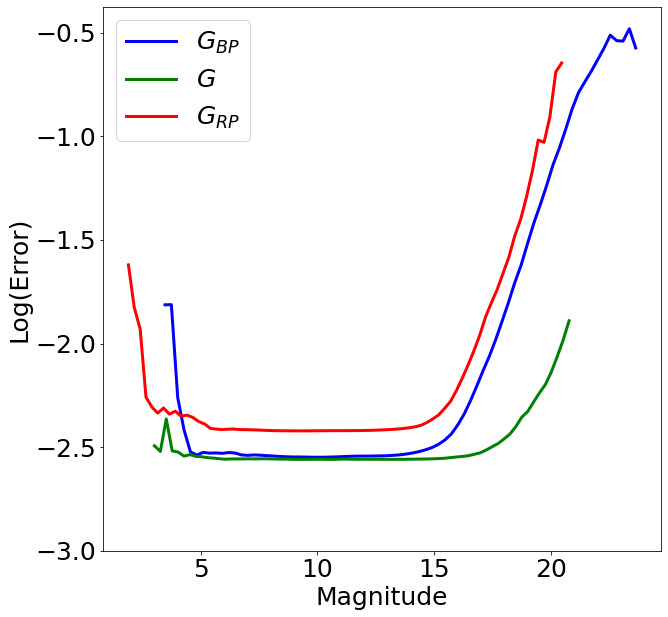

In [87]:
### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(gmin,gmax,gdiff/binnum),gbin,lw=3.0,c='green',label=r'$G$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)')
plt.savefig('../plots/gaiaerrorcurve.pdf',dpi=300,bbox_inches='tight');

In [88]:
from scipy.interpolate import BSpline


teff_tck = (np.array([3527.46704102, 3527.46704102, 3527.46704102, 3527.46704102, 3708.91847923, 3890.36991744, 
                      4071.82144442, 4253.27263849, 4434.72434304, 4616.17578125, 4797.62695312, 4979.07848011,
                      5160.53018466, 5341.98144531, 5523.43261719, 5523.43261719, 5523.43261719, 5523.43261719]),
            np.array([ -36.38271977,  -43.37201334,  -17.08585409,   67.8896712 , 69.84606503,  100.46933976,  
                      103.94758719,   75.90855137,60.21227975,   -5.14343676,   -6.42134699,  217.36965544,
                      -447.26168354, -197.7697192 ,    0.        ,    0.        , 0.        ,    0.        ]),3)


tcorr_spl = BSpline(teff_tck[0],teff_tck[1],teff_tck[2])

tcorr = tcorr_spl(lmcdr17['FPARAM'][:,0])+lmcdr17['FPARAM'][:,0]

mh_tck = (np.array([-2.21858025e+00, -2.21858025e+00, -2.21858025e+00, -2.21858025e+00, -1.96716837e+00,
                    -1.71575650e+00, -1.46434463e+00, -1.21293276e+00, -9.61520889e-01, -7.10109077e-01,
                    -4.58697175e-01, -2.07285313e-01, 4.41265486e-02, 2.95538409e-01, 5.46950281e-01, 
                    5.46950281e-01, 5.46950281e-01, 5.46950281e-01]),
          np.array([1.12848696e+02, 1.00546777e+02, 1.15992357e+02, 9.79509398e+01, 3.87315323e+01, 
                    1.86357031e+01, -1.50821811e+01, 1.21509274e+01, 6.69424869e+00, -2.90025110e+00,
                    -2.68067104e+01, -3.13392475e+01, -8.25826363e+01,-6.49082047e+01, 0.00000000e+00, 
                    0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),3)

teff_cal = BSpline(mh_tck[0],mh_tck[1],mh_tck[2])(lmcdr17['FPARAM'][:,3])+tcorr

In [89]:
agetab = fits.getdata('lmc_dr17_lm_calteff_31AUG2022.fits')
ygridage = np.where(agetab['AGE']==0.0)
ygridage

(array([   1,    2,    3,    4,   24,   25,   29,   33,   36,   38,   43,
          72,   83,   85,   87,   97,  112,  115,  122,  123,  130,  131,
         137,  142,  148,  157,  160,  162,  163,  171,  187,  196,  211,
         335,  346,  363,  376,  379,  396,  404,  431,  438,  440,  460,
         463,  467,  473,  474,  477,  478,  482,  489,  491,  502,  515,
         526,  527,  533,  546,  556,  560,  569,  572,  576,  578,  581,
         586,  587,  588,  591,  595,  603,  612,  618,  620,  640,  641,
         659,  665,  668,  679,  680,  687,  697,  705,  708,  709,  714,
         716,  735,  746,  750,  774,  777,  792,  797,  803,  809,  816,
         823,  827,  837,  846,  859,  860,  866,  870,  877,  883,  884,
         886,  892,  894,  901,  905,  913,  925,  929,  940,  948,  953,
         961,  970,  971,  984,  985,  987,  990,  994,  998, 1009, 1024,
        1032, 1040, 1046, 1052, 1057, 1074, 1107, 1113, 1119, 1137, 1138,
        1143, 1145, 1158, 1159, 1166, 

(array([600.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.]),
 array([     0. ,  99999.9, 199999.8, 299999.7, 399999.6, 499999.5,
        599999.4, 699999.3, 799999.2, 899999.1, 999999. ]),
 <BarContainer object of 10 artists>)

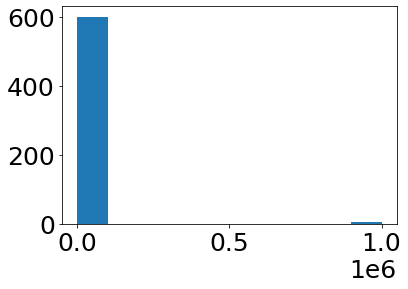

In [159]:
plt.hist(agetab['AGE'][np.where(agetab['EXT'][:,1]==999999.0)])

# Star

In [93]:
star = np.where(lmcdr17['APOGEE_ID']=='2M04593466-7058582')

# # star = np.where(lmcdr17['APOGEE_ID']=='2M05200753-6945446')
# # star

# star = np.where(lmcdr17['APOGEE_ID']==lmcdr17['APOGEE_ID'][ygridage][131])
# star

In [96]:
salfeh

array([-0.5057756 , -1.1278341 , -0.9348752 , ..., -0.48955655,
       -1.0945913 , -1.4116925 ], dtype=float32)

In [162]:
star_ext = 999999.0*np.ones(6)
star_ext_err = 999999.0*np.ones(6)
star_age = 999999.0
star_chi = 999999.0
star_rms = 999999.0
star_mass = 999999.0
    
# Initialize Aetas 
#     te = np.array([lmcdr17['TEFF'][star],lmcdr17['TEFF_ERR'][star]])

te = np.array([teff_cal[star],lmcdr17['TEFF_ERR'][star]])

lg = np.array([lmcdr17['LOGG'][star],lmcdr17['LOGG_ERR'][star]])

ab = np.array([lmcdr17['FE_H'][star],apoafe[star],
               lmcdr17['FE_H_ERR'][star],apoafe_err[star]]).reshape((2,2)).T

op = np.array([lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][star],
               lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][star],
               lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][star],
               lmcdr17['J'][star],lmcdr17['H'][star],lmcdr17['K'][star],
               bperr[star],gerr[star],rperr[star],lmcdr17['J_ERR'][star],
               lmcdr17['H_ERR'][star],lmcdr17['K_ERR'][star]]).reshape((2,6)).T

di = lmcdis[star]*1000

CalcAge = Aetas(te,lg,ab,op,di,massive)
print(CalcAge.extlaw_coeff)

exts = CalcAge.extinction()
star_ext,star_ext_err = exts[:,0],exts[:,1]

star_age,star_chi,star_rms = CalcAge.get_age()
# star_mass = CalcAge.age_2_mass(star_age)

[1.02330779 0.84000359 0.64685287 0.28779332 0.18229774 0.11557049]


In [157]:
star_ext[1]

0.03755280206782006

In [105]:
star_iso.columns

<TableColumns names=('MH','Mass','logAge','logTe','logg','GEDR3mag','G_BPEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag')>

In [151]:
85*1000*6130/10**6

521.05

In [142]:
iso_feh

-0.86

In [139]:
np.log10(star_age*10**9)

9.841322579054841

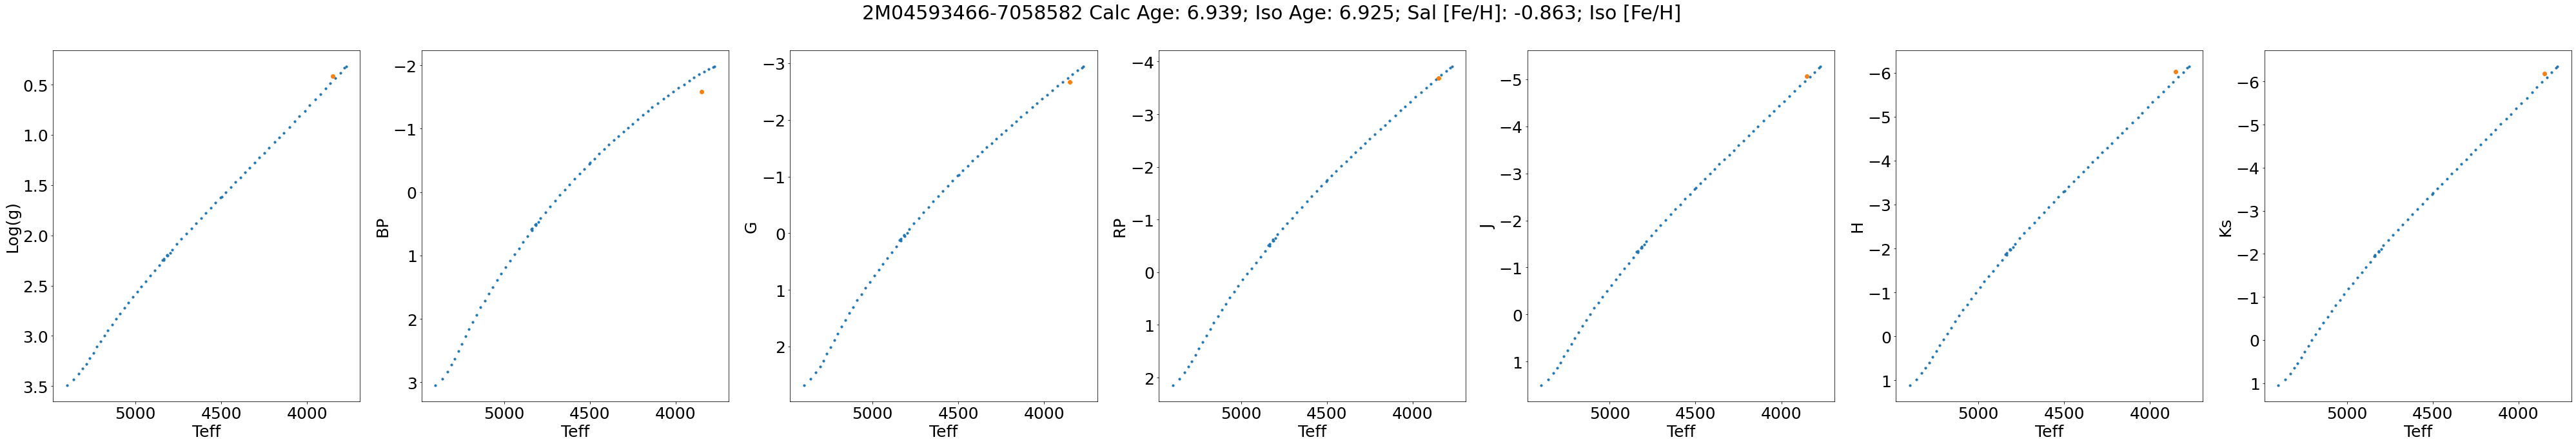

In [149]:
star_iso = massive[np.where((massive['MH']==closest(massive['MH'],salfeh[star]))&
                            (massive['logAge']==closest(massive['logAge'],np.log10(star_age*10**9))))]

star_name = lmcdr17['APOGEE_ID'][star]
star_salfeh = salfeh[star]
iso_age = 10**closest(massive['logAge'],np.log10(star_age*10**9))/10**9
iso_feh = closest(massive['MH'],salfeh[star])

plt.figure(figsize=[70,10])
plt.subplot(171)
plt.scatter(10**star_iso['logTe'],star_iso['logg'],s=10)
plt.scatter(lmcdr17['TEFF'][star],lmcdr17['LOGG'][star])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.subplot(172)
plt.scatter(10**star_iso['logTe'],star_iso['G_BPEDR3mag'],s=10)
plt.scatter(lmcdr17['TEFF'][star],
            lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][star]-star_ext[0]-5*np.log10(lmcdis[star]*1000)+5)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'Teff')
plt.ylabel(r'BP')

plt.subplot(173)
plt.scatter(10**star_iso['logTe'],star_iso['GEDR3mag'],s=10)
plt.scatter(lmcdr17['TEFF'][star],
            lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][star]-star_ext[1]-5*np.log10(lmcdis[star]*1000)+5)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'Teff')
plt.ylabel(r'G')

plt.subplot(174)
plt.scatter(10**star_iso['logTe'],star_iso['G_RPEDR3mag'],s=10)
plt.scatter(lmcdr17['TEFF'][star],
            lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][star]-star_ext[2]-5*np.log10(lmcdis[star]*1000)+5)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'Teff')
plt.ylabel(r'RP')

plt.subplot(175)
plt.scatter(10**star_iso['logTe'],star_iso['Jmag'],s=10)
plt.scatter(lmcdr17['TEFF'][star],lmcdr17['J'][star]-star_ext[3]-5*np.log10(lmcdis[star]*1000)+5)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'Teff')
plt.ylabel(r'J')

plt.subplot(176)
plt.scatter(10**star_iso['logTe'],star_iso['Hmag'],s=10)
plt.scatter(lmcdr17['TEFF'][star],lmcdr17['H'][star]-star_ext[4]-5*np.log10(lmcdis[star]*1000)+5)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'Teff')
plt.ylabel(r'H')

plt.subplot(177)
plt.scatter(10**star_iso['logTe'],star_iso['Ksmag'],s=10)
plt.scatter(lmcdr17['TEFF'][star],lmcdr17['K'][star]-star_ext[5]-5*np.log10(lmcdis[star]*1000)+5)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'Teff')
plt.ylabel(r'Ks')

plt.suptitle(r'{} Calc Age: {:.3f}; Iso Age: {:.3f}; Sal [Fe/H]: {:.3f}; Iso [Fe/H]'.format(star_name[0],float(star_age),float(iso_age),float(star_salfeh),float(iso_feh)))

plt.savefig('{}.png'.format(str(star_name)),bbox_inches='tight')
plt.show()

In [143]:
star_name,star_age,iso_age,star_salfeh,iso_feh

(chararray(['2M04593466-7058582'], dtype='<U18'),
 6.9394105026591,
 6.925003544081933,
 array([-0.8629866], dtype=float32),
 -0.86)

In [55]:
np.array([lmcdr17['FE_H'][star],apoafe[star],
               lmcdr17['FE_H_ERR'][star],apoafe_err[star]])

array([[-0.51156   ],
       [ 0.07584003],
       [ 0.01227618],
       [ 0.51172125]], dtype=float32)

In [67]:
test_feh = massive[np.where(massive['MH']==closest(massive['MH'],lmcdr17['FE_H'][star]))]
print(10**np.nanmin(test_feh['logTe'])-teff_cal[star])

[134.74885635]


In [72]:
agetab[ygridage]['EXT'][:,1]

array([9.99999000e+05, 9.99999000e+05, 9.99999000e+05, 9.99999000e+05,
       9.16758054e-02, 7.29004073e-01, 9.99999000e+05, 1.00008905e-01,
       9.99999000e+05, 1.58916596e-01, 9.99999000e+05, 9.99999000e+05,
       9.99999000e+05, 9.99999000e+05, 9.99999000e+05, 2.87992893e-01,
       9.99999000e+05, 9.99999000e+05, 2.21488885e-01, 9.99999000e+05,
       9.99999000e+05, 9.99999000e+05, 9.99999000e+05, 9.99999000e+05,
       9.99999000e+05, 9.99999000e+05, 9.99999000e+05, 9.99999000e+05,
       9.99999000e+05, 1.16677482e-02, 9.99999000e+05, 4.38014817e-02,
       9.99999000e+05, 9.99999000e+05, 3.63692676e-02, 9.99999000e+05,
       9.99999000e+05, 9.99999000e+05, 1.72539056e-01, 9.99999000e+05,
       9.99999000e+05, 2.75177455e-02, 9.99999000e+05, 3.01453778e-02,
       9.99999000e+05, 9.99999000e+05, 9.99999000e+05, 9.99999000e+05,
       1.82360548e-01, 2.93754902e-02, 9.99999000e+05, 9.99999000e+05,
       9.99999000e+05, 9.99999000e+05, 9.99999000e+05, 9.99999000e+05,
      

In [69]:
gridage_teffdiff = 999999.0*np.ones(len(np.squeeze(ygridage)))

for i in range(len(lmcdr17[ygridage])):
    iso_feh = massive[np.where(massive['MH']==closest(massive['MH'],lmcdr17['FE_H'][ygridage][i]))]
    gridage_teffdiff[i] = 10**np.nanmin(iso_feh['logTe'])-teff_cal[ygridage][i] 

In [70]:
print(gridage_teffdiff)

[ 1.11874548e+02  4.04733266e+01  5.09948898e+01  1.42820796e+01
 -1.77003848e+01 -2.67821581e+02  9.77139576e+01 -2.36468155e+01
  5.26598554e+01 -8.10974157e+00  5.87771127e+01 -1.24663145e+01
  3.57790561e+01  2.83014293e+01  2.21917889e+02 -3.96937949e+02
  2.74696191e+01  6.39417982e+01 -1.19470421e+03  4.38277320e+01
  1.48192662e+01  6.28691522e+02 -1.41904572e+01  2.56346083e+02
  3.10865438e+01  7.87424693e+01  3.53461197e+01  1.76641372e+01
  3.24562180e+02 -2.14819782e+01  5.20966295e+01 -6.54589195e-01
  4.21653178e+01  3.69801750e+01 -2.63518209e+01  9.16842117e+01
  6.39767163e+02  8.96037068e+01 -2.56687781e+02  1.40174351e+02
  1.64449444e+01 -4.72085462e+01  7.70379970e+01  7.28733953e+00
  3.27858360e+01  3.23679388e+01  5.85676339e+01  2.67071387e+02
 -1.78371314e+01 -2.90313075e+01  1.56032797e+01  3.67437079e+02
  1.40619733e+02  2.56757530e+01  2.45046505e+01  2.30913189e+01
 -1.75486566e+01  1.76821687e+02  4.09498573e+01  8.87742323e+01
  9.02619666e+01  4.45727

In [63]:
star_age

0.012

In [17]:
np.linspace(0.012,17.)[::10]

array([1.20000000e-02, 3.47893878e+00, 6.94587755e+00, 1.04128163e+01,
       1.38797551e+01])

(array([ 1.,  0.,  1.,  1.,  0.,  2.,  8.,  4., 12.,  9.,  9., 14.,  7.,
         8.,  9.,  4.,  4.,  4.,  1.,  2.]),
 array([3651.13228836, 3653.76038563, 3656.3884829 , 3659.01658017,
        3661.64467744, 3664.27277471, 3666.90087198, 3669.52896925,
        3672.15706652, 3674.7851638 , 3677.41326107, 3680.04135834,
        3682.66945561, 3685.29755288, 3687.92565015, 3690.55374742,
        3693.18184469, 3695.80994196, 3698.43803923, 3701.0661365 ,
        3703.69423377]),
 <BarContainer object of 20 artists>)

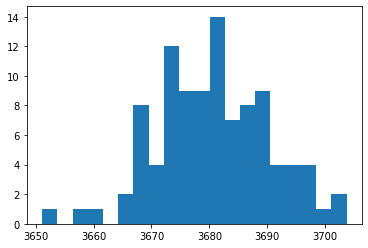

In [18]:
plt.hist(np.random.normal(loc=teff_cal[star],scale=lmcdr17['TEFF_ERR'][star],size=100),bins=20)

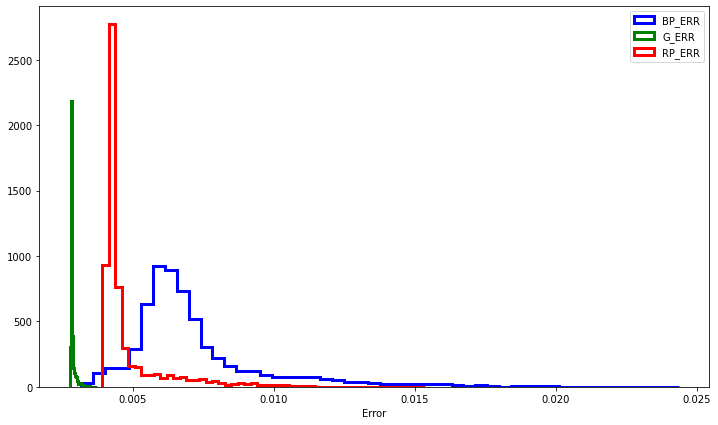

In [19]:
plt.figure(figsize=[12,7])
plt.hist(bperr,bins=50,histtype='step',lw=3.0,label='BP_ERR',color='blue')
plt.hist(gerr,bins=50,histtype='step',lw=3.0,label='G_ERR',color='green')
plt.hist(rperr,bins=50,histtype='step',lw=3.0,label='RP_ERR',color='red')
plt.legend()
plt.xlabel(r'Error')
plt.show()

(array([ 3.,  1.,  1.,  1.,  6.,  9.,  7., 12.,  4., 13.,  7.,  5.,  4.,
         2.,  6.,  6.,  7.,  4.,  1.,  1.]),
 array([0.00272163, 0.00273587, 0.00275011, 0.00276435, 0.00277859,
        0.00279283, 0.00280707, 0.00282131, 0.00283555, 0.0028498 ,
        0.00286404, 0.00287828, 0.00289252, 0.00290676, 0.002921  ,
        0.00293524, 0.00294948, 0.00296372, 0.00297796, 0.0029922 ,
        0.00300644]),
 <BarContainer object of 20 artists>)

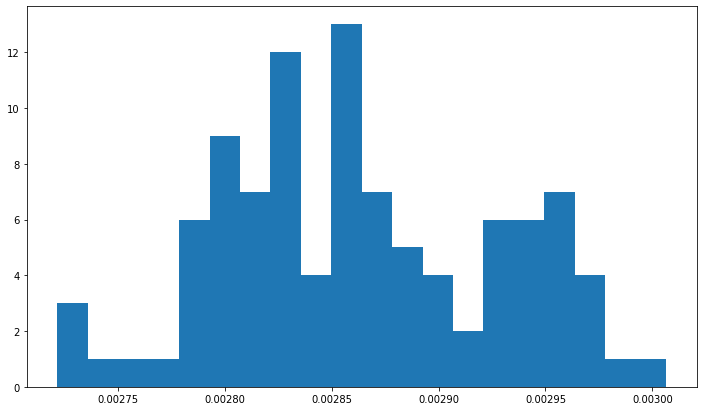

In [20]:
plt.figure(figsize=[12,7])
plt.hist(np.random.normal(loc=np.mean(gerr),scale=np.std(gerr),size=100),bins=20)

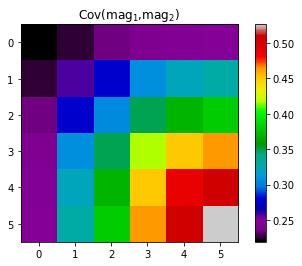

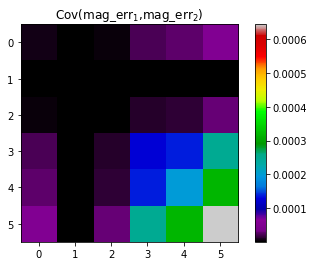

In [21]:
mag_fin = np.where((np.isfinite(lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'])==True)&
                   (np.isfinite(lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'])==True)&
                   (np.isfinite(lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])==True)&
                   (np.isfinite(lmcdr17['J'])==True)&(np.isfinite(lmcdr17['H'])==True)&
                   (np.isfinite(lmcdr17['K'])==True))

mag_cov = np.cov(np.array([lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][mag_fin],
                           lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][mag_fin],
                           lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][mag_fin],
                           lmcdr17['J'][mag_fin],lmcdr17['H'][mag_fin],lmcdr17['K'][mag_fin]]))

plt.figure()
plt.imshow(mag_cov,cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Cov(mag$_1$,mag$_2$)')
plt.show()

err_fin = np.where((np.isfinite(bperr)==True)&(np.isfinite(gerr)==True)&(np.isfinite(rperr)==True)&
         (np.isfinite(lmcdr17['J_ERR'])==True)&(np.isfinite(lmcdr17['H_ERR'])==True)&
         (np.isfinite(lmcdr17['K_ERR'])==True))

mag_err_cov = np.cov(np.array([bperr[err_fin],gerr[err_fin],rperr[err_fin],lmcdr17['J_ERR'][err_fin],
                 lmcdr17['H_ERR'][err_fin],lmcdr17['K_ERR'][err_fin]]))

plt.figure()
plt.imshow(mag_err_cov,cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Cov(mag_err$_1$,mag_err$_2$)')
plt.show()

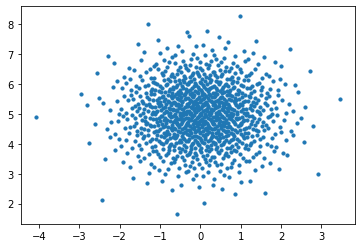

In [22]:
import matplotlib.pyplot as plt
from scipy.stats import qmc
dist = qmc.MultivariateNormalQMC(mean=[0, 5], cov=[[1, 0], [0, 1]])
sample = dist.random(1024)
_ = plt.scatter(sample[:, 0], sample[:, 1], s=10)
plt.show()

In [23]:
np.diag(np.ones((6,6)))

array([1., 1., 1., 1., 1., 1.])

In [24]:
mags = np.array([lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][star][0],lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][star][0],
                 lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][star][0],lmcdr17['J'][star][0],lmcdr17['H'][star][0],
                 lmcdr17['K'][star][0]])

test = qmc.MultivariateNormalQMC(mean=mags,cov=mag_cov)
test.random(4)

array([[16.71949688, 15.61076725, 14.58914371, 13.16813046, 12.24902116,
        12.05170203],
       [17.83812467, 17.04398213, 16.1701559 , 15.17009182, 14.2693244 ,
        14.21143038],
       [17.1177076 , 15.91234221, 14.85909302, 13.24187175, 12.24990659,
        12.10589884],
       [16.5168269 , 15.48453233, 14.44585862, 13.08610255, 12.27009768,
        12.0073035 ]])

In [25]:
np.array([lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][star],lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][star],
          lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][star],lmcdr17['J'][star],lmcdr17['H'][star],lmcdr17['K'][star]])

array([[17.0106],
       [15.9139],
       [14.887 ],
       [13.486 ],
       [12.535 ],
       [12.362 ]], dtype=float32)

In [26]:
np.random.multivariate_normal([lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][star][0],
                               lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][star][0],
                               lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][star][0],
                               lmcdr17['J'][star][0],lmcdr17['H'][star][0],lmcdr17['K'][star][0]],
                              mag_cov,size=4)

array([[16.3376669 , 15.22734451, 14.23424438, 12.86935498, 12.04478551,
        11.81297728],
       [17.01096408, 16.21562489, 15.31076102, 13.99951599, 13.1599097 ,
        13.06885179],
       [17.27322598, 16.19397442, 15.2160904 , 13.94752109, 13.04247994,
        12.86888143],
       [16.62271736, 15.79811051, 14.92585569, 13.82678222, 13.04912694,
        12.89298383]])

In [27]:
test_cov = np.diag([bperr[star][0],gerr[star][0],rperr[star][0],lmcdr17['J_ERR'][star][0],
                    lmcdr17['H_ERR'][star][0],lmcdr17['K_ERR'][star][0],lmcdr17['TEFF_ERR'][star][0]])

test_samp = np.random.multivariate_normal([lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][star][0],
                               lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][star][0],
                               lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][star][0],
                               lmcdr17['J'][star][0],lmcdr17['H'][star][0],
                               lmcdr17['K'][star][0],teff_cal[star][0]],
                              test_cov,size=4)

test_samp[:,-1]

array([3678.1431465 , 3680.99308858, 3686.56538584, 3681.99523118])

In [28]:
[lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][star][0],
                                        lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][star][0],
                                        lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][star][0],
                                        lmcdr17['J'][star][0],lmcdr17['H'][star][0],lmcdr17['K'][star][0]]

[17.0106, 15.9139, 14.887, 13.486, 12.535, 12.362]

In [29]:
np.diag([bperr[star][0],gerr[star][0],rperr[star][0],lmcdr17['J_ERR'][star][0],lmcdr17['H_ERR'][star][0],
         lmcdr17['K_ERR'][star][0]])

array([[0.00689291, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.00283045, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00423762, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.024     , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.027     ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.026     ]])

In [30]:
np.sqrt(np.sum(np.reciprocal([bperr[star][0],gerr[star][0],rperr[star][0],lmcdr17['J_ERR'][star][0],lmcdr17['H_ERR'][star][0],
         lmcdr17['K_ERR'][star][0]])))/2

14.590445158202169

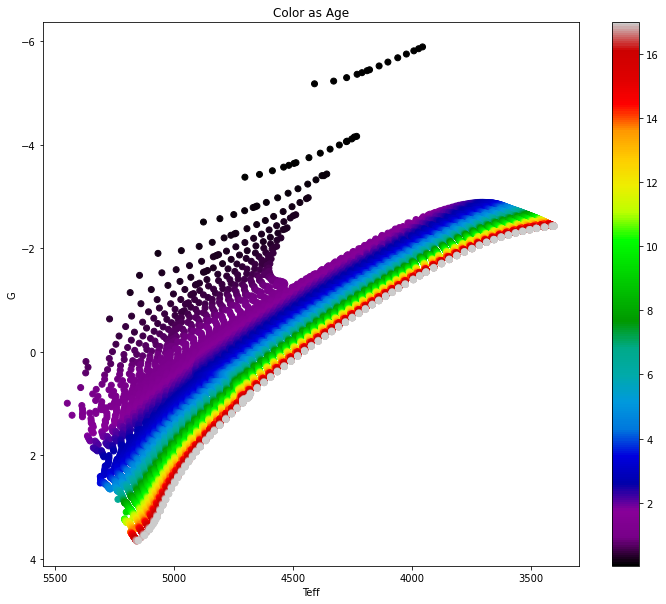

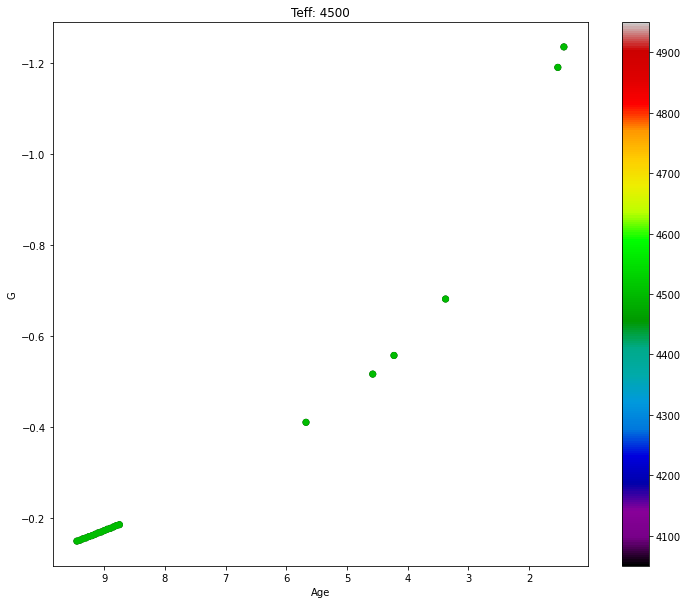

In [31]:
singfeh = massive[np.where(massive['MH']==closest(massive['MH'],-0.5))]

teffclose = np.where(singfeh['logTe']==closest(singfeh['logTe'],np.log10(4500)))

plt.figure(figsize=[12,10])
plt.scatter(10**singfeh['logTe'],singfeh['GEDR3mag'],c=10**singfeh['logAge']/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title(r'Color as Age')
plt.xlabel(r'Teff')
plt.ylabel(r'G')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(10**singfeh['logAge'][teffclose]/10**9,singfeh['GEDR3mag'][teffclose],
            c=10**singfeh['logTe'][teffclose],cmap='nipy_spectral')
plt.scatter(10**singfeh['logAge'][teffclose]/10**9,singfeh['GEDR3mag'][teffclose],
            c=10**singfeh['logTe'][teffclose],cmap='nipy_spectral')
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title(r'Teff: 4500')
plt.xlabel(r'Age')
plt.ylabel(r'G')
plt.show()

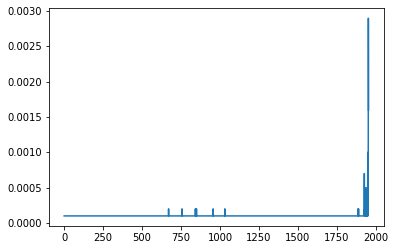

In [32]:
plt.plot(np.diff(np.unique(singfeh['logTe'])))

# Whole LMC

In [ ]:
# lmc_ext = 999999.0*np.ones((len(lmcdr17),6))
# lmc_ext_err = 999999.0*np.ones((len(lmcdr17),6))
# lmc_age = 999999.0*np.ones(len(lmcdr17))
# lmc_chi = 999999.0*np.ones(len(lmcdr17))
# lmc_rms = 999999.0*np.ones(len(lmcdr17))
# lmc_mass = 999999.0*np.ones(len(lmcdr17))

# for i in tqdm(range(len(lmcdr17))):
    
#     # Initialize Aetas 
#     te = np.array([teff_cal[i],lmcdr17['TEFF_ERR'][i]])
    
#     lg = np.array([lmcdr17['LOGG'][i],lmcdr17['LOGG_ERR'][i]])
    
#     ab = np.array([[lmcdr17['FE_H'][i],apoafe[i]],
#                    [lmcdr17['FE_H_ERR'][i],apoafe_err[i]]]).T
    
#     op = np.array([[lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
#                     lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][i],
#                     lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
#                     lmcdr17['J'][i],lmcdr17['H'][i],lmcdr17['K'][i]],
#                    [bperr[i],gerr[i],rperr[i],lmcdr17['J_ERR'][i],
#                     lmcdr17['H_ERR'][i],lmcdr17['K_ERR'][i]]]).T
    
#     di = lmcdis[i]*1000 #(1/lmcdr17['GAIAEDR3_PARALLAX'][i])*1000

#     CalcAge = Aetas(te,lg,ab,op,di,massive)
    
#     exts = CalcAge.extinction()
#     lmc_ext[i,:],lmc_ext_err[i,:] = exts[:,0],exts[:,1]

#     lmc_age[i],lmc_chi[i],lmc_rms[i] = CalcAge.get_age()
#     lmc_mass[i] = CalcAge.age_2_mass(lmc_age[i])

  0%|          | 0/6130 [00:00<?, ?it/s]

<ipython-input-4-4a8f88672c7e>:369: RuntimeWarning: invalid value encountered in log10
  lgage = np.log10(age*10**9)
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:630: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = NX.asarray(y) + 0.0


In [79]:
interp(np.linspace(0,1),np.linspace(0,1),0.5)

AttributeError: 'numpy.ndarray' object has no attribute '_spline'